## 二八轮动策略
指的是市值最大的前 20% 数量的大盘股和剩下数目占 80% 的中小盘股之间的轮动，根据动量，就是资产近期涨幅的横向排名，看谁过去涨得多就买谁。
1. 二八轮动：满仓版本
- 沪深300代表大盘股，中证500代表小盘股，比较20天内的涨幅，哪个大 买哪个。
2. 二八轮动：有空仓版
- 空仓版：当回看 20 个交易日涨幅时，如果两个指数均为下跌，就选择空仓。

          AnnRet    AnnVol        SR     MaxDD    Calmar
hs300   0.097968  0.263049  0.372432 -0.723038  0.135495
csi500  0.122693  0.299014  0.410326 -0.724171  0.169426
stgy    0.201383  0.281292  0.715922  -0.68404  0.294402
          AnnRet    AnnVol        SR     MaxDD    Calmar
hs300   0.097968  0.263049  0.372432 -0.723038  0.135495
csi500  0.122693  0.299014  0.410326 -0.724171  0.169426
stgy    0.262763  0.211737  1.240989 -0.359963  0.729973


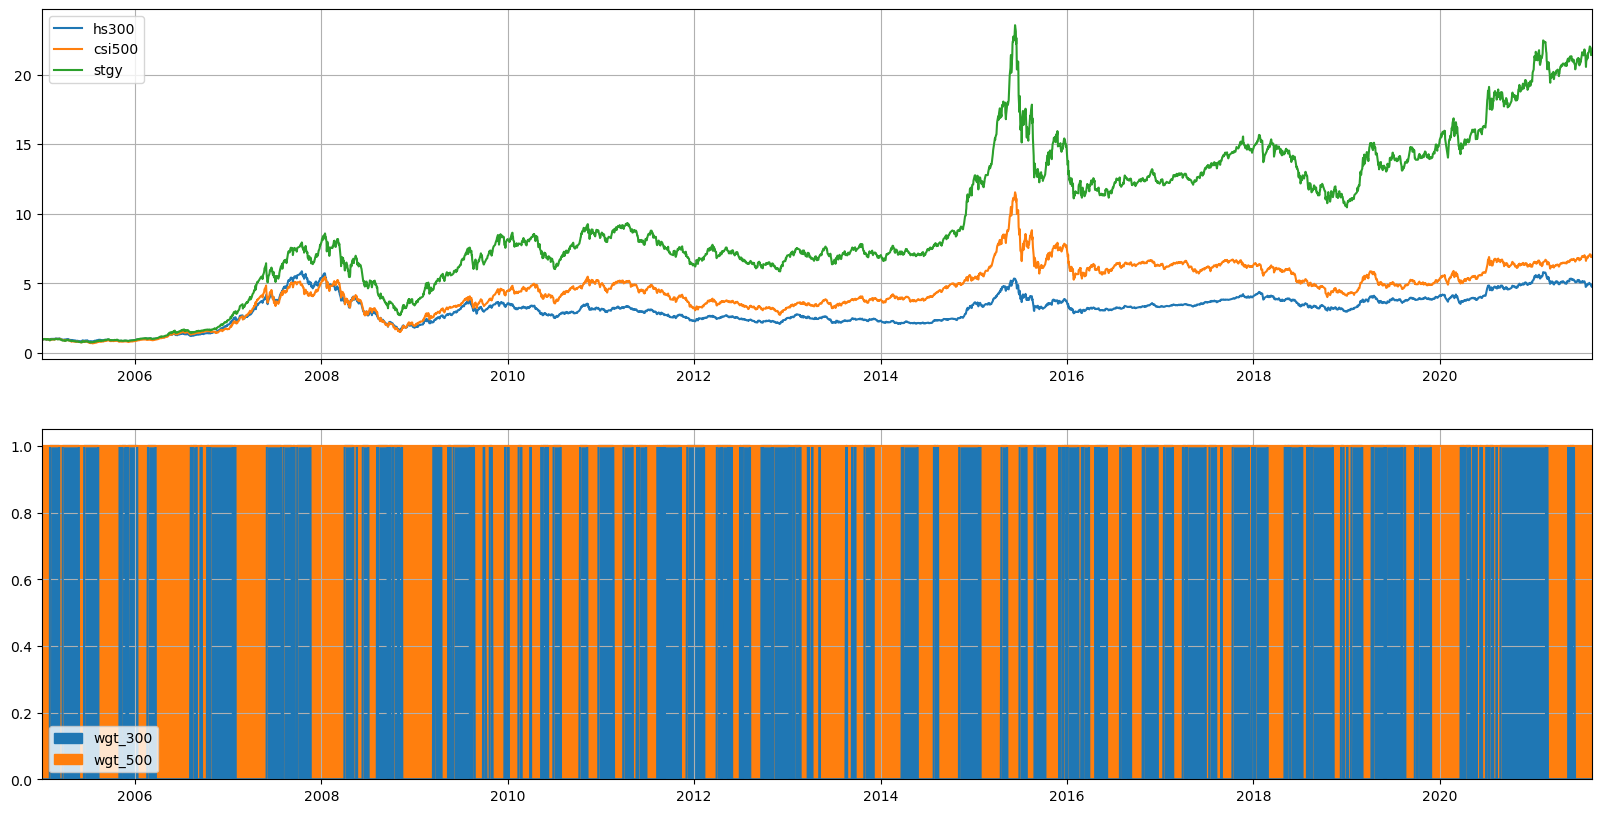

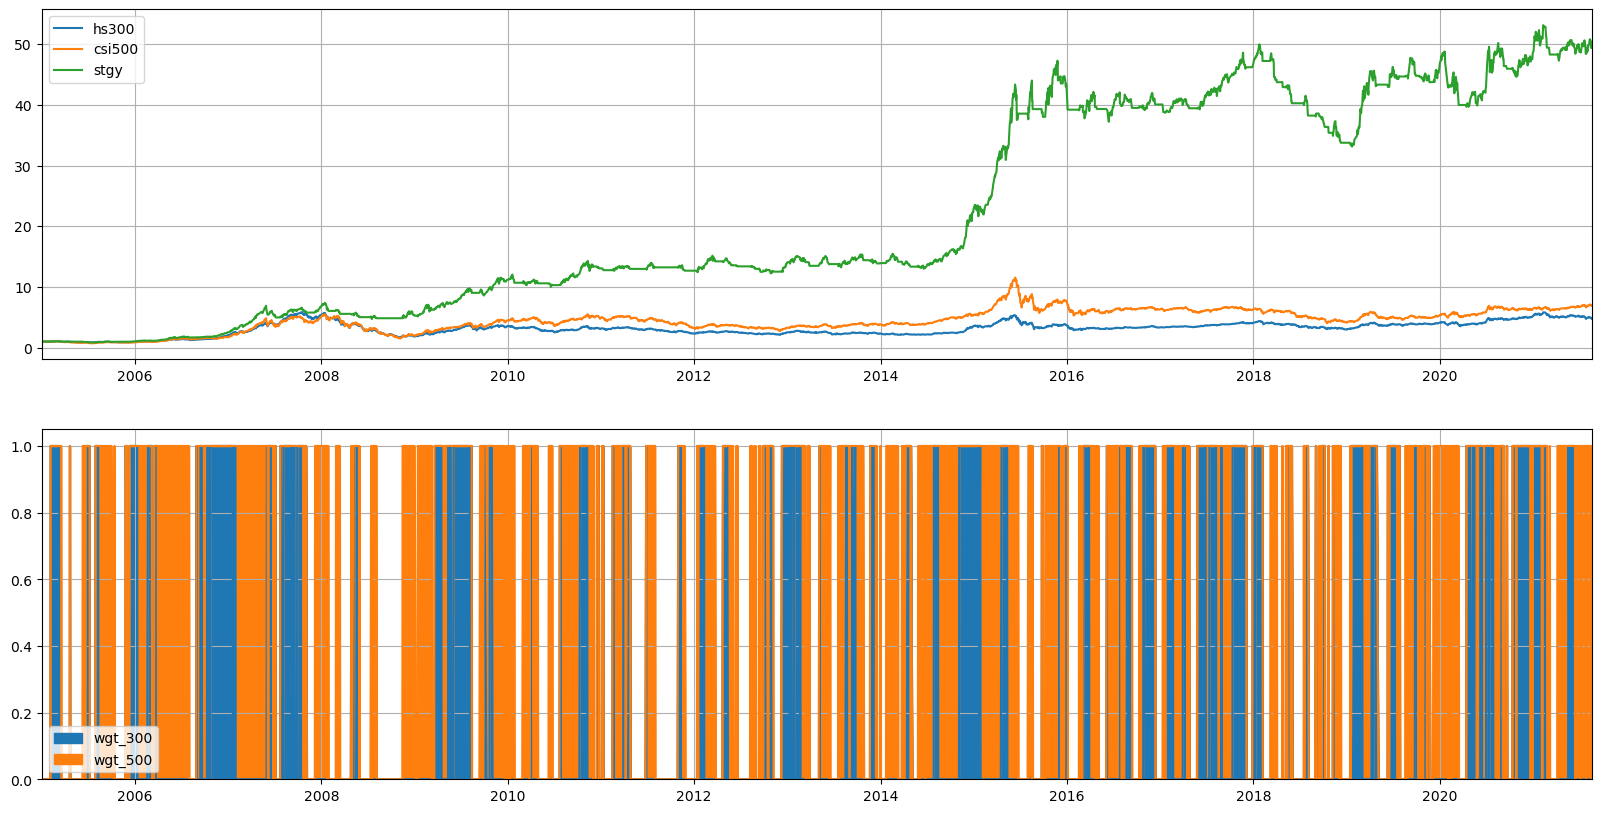

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


def get_drawdown(p):
    hmax = p.cummax()
    return p / hmax - 1


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """
    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        return res
    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242 / len(adjnav)) - 1  # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd
    return [annret, annvol, sr, mdd, calmar]


def datestr2dtdate(datestr):
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


# 从csv文件获取指数价格数据
index_price = pd.read_csv('300和500历史数据.csv').set_index('datetime')
index_price.index = [datestr2dtdate(e) for e in index_price.index]

# 二八轮动：满仓版本
# 沪深300代表大盘股，中证500代表小盘股，  比较20天内的涨幅，哪个大 买哪个。
N = 20
df = index_price.copy()
df['ret_300'] = df['hs300'].pct_change()
df['ret_500'] = df['csi500'].pct_change()
# .shift 是向前移动N个单位。
df['N_day_ret_300'] = df['hs300'] / df['hs300'].shift(N) - 1         # N_day_ret_300 表示从前 N 天到当前这一天的沪深300指数的收益率。
df['N_day_ret_500'] = df['csi500'] / df['csi500'].shift(N) - 1
df['momentum_300_vs_500'] = df['N_day_ret_300'] - df['N_day_ret_500']   # 得到差值
df['wgt_300'] = [1 if e > 0 else 0 for e in df['momentum_300_vs_500'].shift(1)]     # 今天按照前一条的结果判断后 买入谁。
df['wgt_500'] = 1 - df['wgt_300']   # 标记买入的500
df['ret_stgy'] = df['ret_300'] * df['wgt_300'] + df['ret_500'] * df['wgt_500']  # 期间买入的 300 + 500 的收益率
df['hs300'] = (1 + df['ret_300']).cumprod().fillna(1)
df['csi500'] = (1 + df['ret_500']).cumprod().fillna(1)      #
df['stgy'] = (1 + df['ret_stgy']).cumprod().fillna(1)       # 策略总收益

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 1, 1)
df.loc[:, ['hs300', 'csi500', 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0], df.index[-1])
ax2 = fig.add_subplot(2, 1, 2)
df[['wgt_300', 'wgt_500']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0], df.index[-1])
res = cal_period_perf_indicator(df.loc[:, ['hs300', 'csi500', 'stgy']])
print(res)


# 二八轮动：有空仓版
# 空仓版：当回看 20 个交易日涨幅时，如果两个指数均为下跌，就选择空仓。
N = 20
df = index_price.copy()
df['ret_300'] = df['hs300'].pct_change()
df['ret_500'] = df['csi500'].pct_change()
df['N_day_ret_300'] = df['hs300'] / df['hs300'].shift(N) - 1
df['N_day_ret_500'] = df['csi500'] / df['csi500'].shift(N) - 1

df['wgt_300'] = 0
df['wgt_500'] = 0
for i in range(1, len(df)):
    t = df.index[i]
    t0 = df.index[i - 1]
    if df.loc[t0, 'N_day_ret_300'] >= df.loc[t0, 'N_day_ret_500'] and df.loc[t0, 'N_day_ret_300'] > 0:
        df.loc[t, 'wgt_300'] = 1
    elif df.loc[t0, 'N_day_ret_500'] > df.loc[t0, 'N_day_ret_300'] and df.loc[t0, 'N_day_ret_500'] > 0:
        df.loc[t, 'wgt_500'] = 1

df['ret_stgy'] = df['ret_300'] * df['wgt_300'] + df['ret_500'] * df['wgt_500']
df['hs300'] = (1 + df['ret_300']).cumprod().fillna(1)
df['csi500'] = (1 + df['ret_500']).cumprod().fillna(1)
df['stgy'] = (1 + df['ret_stgy']).cumprod().fillna(1)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 1, 1)
df.loc[:, ['hs300', 'csi500', 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0], df.index[-1])

ax2 = fig.add_subplot(2, 1, 2)
df[['wgt_300', 'wgt_500']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0], df.index[-1])

res = cal_period_perf_indicator(df.loc[:, ['hs300', 'csi500', 'stgy']])
print(res)